# Quantum pipeline using TorchQuantum

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import torch

BATCH_SIZE = 10
EPOCHS = 5
LEARNING_RATE = 0.01
SEED = 2

### Input data

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [ ]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

### Create diagrams

In [4]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

train_diagrams = reader.sentences2diagrams(train_data)
dev_diagrams = reader.sentences2diagrams(dev_data)
test_diagrams = reader.sentences2diagrams(test_data)

/opt/miniconda3/envs/lmbq_tq/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Create circuits

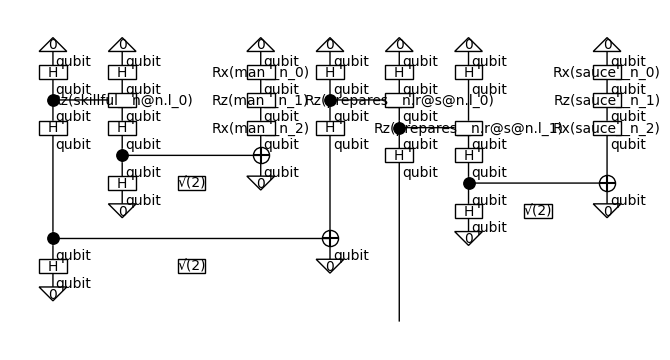

In [5]:
from lambeq.backend.tensor import Dim

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1,
                    AtomicType.SENTENCE: 1}, n_layers=1)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits = train_circuits[:1]
dev_circuits = train_circuits[:1]
test_circuits = train_circuits[:1]

train_labels = train_labels[:1]
dev_labels = train_labels[:1]
test_labels = train_labels[:1]

train_circuits[-1].draw()

### Parameterise

In [6]:
from lambeq import TorchQuantumModel
all_circuits = train_circuits + dev_circuits + test_circuits
model = TorchQuantumModel.from_diagrams(all_circuits)

### Define Evaluation Metric

In [7]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == 
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

### Initialize Trainer

In [8]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=loss,
        optimizer=torch.optim.Adam,    # type: ignore
        learning_rate=LEARNING_RATE,
        device=-1,
        epochs=EPOCHS,
        evaluate_functions={"acc": accuracy},
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)


In [9]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_circuits, dev_labels)

### Train

In [10]:
trainer.fit(train_dataset, dev_dataset, log_interval=1)

Epoch 1:  train/loss: 0.1629   valid/loss: 0.0821   train/time: 0.10s   valid/time: 0.01s   train/time_per_epoch: 0.10s   valid/time_per_eval: 0.01s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 2:  train/loss: 0.0821   valid/loss: 0.0400   train/time: 0.01s   valid/time: 0.01s   train/time_per_epoch: 0.01s   valid/time_per_eval: 0.01s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 3:  train/loss: 0.0400   valid/loss: 0.0193   train/time: 0.01s   valid/time: 0.01s   train/time_per_epoch: 0.01s   valid/time_per_eval: 0.01s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 4:  train/loss: 0.0193   valid/loss: 0.0102   train/time: 0.01s   valid/time: 0.01s   train/time_per_epoch: 0.01s   valid/time_per_eval: 0.01s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 5:  train/loss: 0.0102   valid/loss: 0.0072   train/time: 0.01s   valid/time: 0.01s   train/time_per_epoch: 0.01s   valid/time_per_eval: 0.01s   train/acc: 1.0000   valid/acc: 1.0000

Training completed!
train/time: 0.17s   train/time_per

### Show results

Test accuracy: 1.0


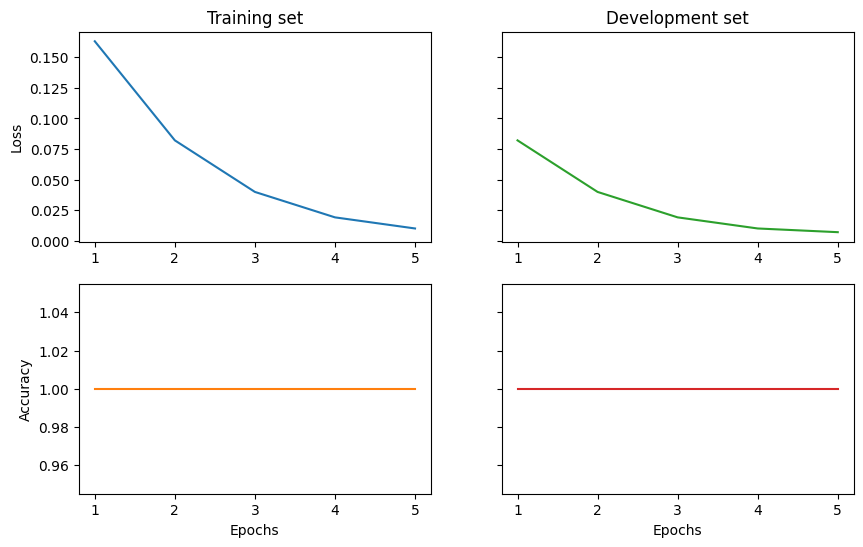

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model.forward(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc)